In [35]:
import numpy as np 
import pandas as pd
import random
import matplotlib.pyplot as plt # to visualize only
from skimage.transform import resize, rescale
from sklearn.model_selection import KFold

In [2]:
data_x_pd = pd.read_csv("./data/processed_x.csv", delimiter=",", header = None) # load from processed images
# train_x = train_x.values # dataframe to numpy ndarray
# train_x = train_x.astype(np.float32)
# train_x /= 255 # normalize

In [3]:
data_y_pd = pd.read_csv("./data/train_y.csv", delimiter = ",", header = None)
# train_y = (train_y.values).ravel()

In [37]:
# Can see resized 28x28 image
def plotter(images, labels, start):
    plt.figure(figsize=(20,4))
    for index, (image, label) in enumerate(zip(images[start:start+5], labels[start:start+5])):
        plt.subplot(1, 5, index + 1)
        im = np.reshape(image, (28,28))
        plt.imshow(im, cmap= 'gray')
        plt.title('Training: %i\n' % label, fontsize = 20)

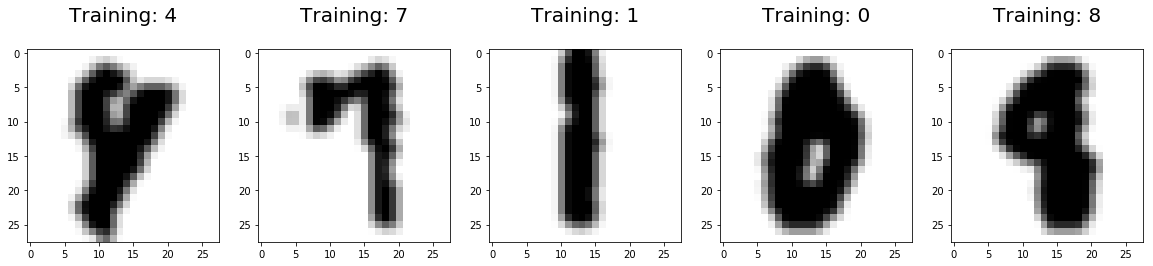

In [40]:
plotter(x, data_y, 0)

In [38]:
### Prepare Data for Neural Net ###

data_x = data_x_pd.head(5000).values.astype(np.float32)
data_y = np.array(list(map(int, data_y_pd.head(5000)[0].tolist())), dtype=object)

# Normalize x values
data_x /= 255

num_rows = 28
num_cols = num_rows

x = np.zeros((data_x.shape[0], num_rows*num_cols))

scale = num_rows/64

for i in range(len(x)):
    img = data_x[i].reshape(64,64)
    image = rescale(img, scale, mode = 'reflect')
    image = image.reshape(28**2)
    x[i] = image

In [149]:
# calculate sigmoid of input

def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

# calculate derivative of sigmoid at the input
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [166]:
class Network(object):

    def __init__(self, dims):
        # dims contains number of neurons in each layer
        # first index is dimension of input (eg. size of image)
        # last layer is dimension of output (10)
        # length of dims is # of layers of network
        # biases and weights are intialized randomly using Gaussian dist 9 (mean 0, sd 1)
        self.num_layers = len(dims)
        self.dims = dims
        self.biases = [np.random.randn(y, 1) for y in dims[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(dims[:-1], dims[1:])]
    
    # calculate value out of first hidden layer
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            valid_data, progress = None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if valid_data: n_valid = len(valid_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            self.update_mini_batch(training_data, eta)
            
            valid_score = self.evaluate(valid_data)
#             print("Epoch {0}: {1} / {2}".format(
#                j, valid_score, n_valid))
            if progress is not None:
                progress[j] = valid_score
            
        return valid_score
        
    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
            
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]  
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

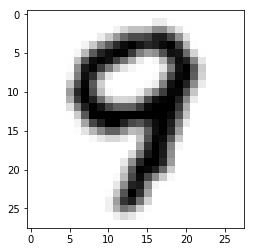

In [135]:
plt.imshow(x[45].reshape(num_rows, num_cols), cmap = 'gray')

In [ ]:
kf = KFold(n_splits=5)
kf.get_n_splits(x)

num_epochs = 2000

layer_dims = [[784,100,10],[784,50,10],[784,100,50, 10],
              [784,200,10]]

learning_rates = [1.0, 4.0, 8.0]

accuracies = []
progress_per_epoch = np.zeros((len(layer_dims)*len(learning_rates), num_epochs))
# print(progress_per_epoch.shape)

In [ ]:
for train_index, valid_index in kf.split(x):
    
    train_x, valid_x = x[train_index], x[valid_index]
    train_y, valid_y = data_y[train_index], data_y[valid_index]
    
    # vectorize training targets
    for i in range(len(train_y)):
        vect = np.zeros((10,1), dtype=object)
        vect[train_y[i]] = 1
        train_y[i] = vect.astype(float)
    
    # reshape and zip train and valid
    training_inputs = [np.reshape(x,(train_x.shape[1],1)) 
                       for x in train_x]
    valid_inputs = [np.reshape(x,(valid_x.shape[1],1)) for x in valid_x]
    training_data = list(zip(training_inputs, train_y))
    valid_data = list(zip(valid_inputs, valid_y))

    
    pos = 0 
    
    for i, dim in enumerate(layer_dims):
        for j, lr in enumerate(learning_rates):
            print("NN dimensions: {}, learning rate: {}, ".format(dim, lr) )
            average_score = 0
            
        
            neural_net = Network(dim)
            valid_score = neural_net.SGD(training_data, num_epochs, 784, lr, valid_data, progress_per_epoch[pos])
            average_score += valid_score
            accuracies.append(average_score/len(valid_x))
            print(average_score)
            pos += 1
             
    
# 
#        neural_net = Network([num_rows*num_cols, 100, 10])
#     valid_score = neural_net.SGD(training_data, num_epochs, 784, 4.0, valid_data)
#     average_score += valid_score
#     average_score /= len(valid_x)
    break

# print average_accuracy / 5.0

In [171]:
kf = KFold(n_splits=5)
kf.get_n_splits(x)

num_epochs = 2500


layer_dims2 = [[784, 50, 100, 10], [784, 70, 30, 70, 10]]


learning_rate = 4.0

accuracies2 = []
progress_per_epoch2 = np.zeros((len(layer_dims2), num_epochs))

# print(progress_per_epoch2.shape)

In [172]:
for train_index, valid_index in kf.split(x):
    
    train_x, valid_x = x[train_index], x[valid_index]
    train_y, valid_y = data_y[train_index], data_y[valid_index]
    
    # vectorize training targets
    for i in range(len(train_y)):
        vect = np.zeros((10,1), dtype=object)
        vect[train_y[i]] = 1
        train_y[i] = vect.astype(float)
    
    # reshape and zip train and valid
    training_inputs = [np.reshape(x,(train_x.shape[1],1)) 
                       for x in train_x]
    valid_inputs = [np.reshape(x,(valid_x.shape[1],1)) for x in valid_x]
    training_data = list(zip(training_inputs, train_y))
    valid_data = list(zip(valid_inputs, valid_y))

    
    pos = 0 
    
    for i, dim in enumerate(layer_dims2):
        print("NN dimensions: {}, learning rate: {}, ".format(dim, learning_rate) )
       
        average_score = 0

        neural_net = Network(dim)
        valid_score = neural_net.SGD(training_data, num_epochs, 784, learning_rate, valid_data, progress_per_epoch2[pos])
        average_score += valid_score
        accuracies2.append(average_score/len(valid_x))
        print(average_score)
        pos += 1

    break

NN dimensions: [784, 50, 100, 10], learning rate: 4.0, 
356
NN dimensions: [784, 70, 30, 70, 10], learning rate: 4.0, 
612


In [140]:
print(accuracies)

[0.461, 0.369, 0.433, 0.624, 0.628, 0.619, 0.718, 0.772, 0.536, 0.109, 0.337, 0.109]


In [141]:
print(progress_per_epoch)

[[ 71.  85.  88. ... 460. 460. 461.]
 [103. 121. 122. ... 369. 369. 369.]
 [ 81. 107. 107. ... 434. 425. 433.]
 ...
 [139. 129. 130. ... 109. 109. 109.]
 [108. 102. 102. ... 338. 339. 337.]
 [126. 124. 123. ... 109. 109. 109.]]


In [143]:
df = pd.DataFrame(accuracies)
df.to_csv("./data/nn_accuracies.csv", header = False, index = False)

In [144]:
df = pd.DataFrame(progress_per_epoch)
df.to_csv("./data/nn_progress.csv", header = False, index = False)

In [175]:
print(progress_per_epoch2[0, 2000:])

[353. 354. 353. 354. 353. 354. 353. 354. 353. 354. 353. 354. 353. 354.
 353. 354. 353. 354. 353. 354. 353. 355. 353. 355. 352. 355. 352. 355.
 352. 355. 352. 355. 352. 355. 352. 355. 352. 355. 352. 355. 352. 355.
 352. 355. 352. 355. 352. 355. 352. 355. 352. 355. 352. 355. 352. 355.
 352. 355. 353. 355. 353. 355. 353. 355. 353. 355. 353. 355. 353. 355.
 353. 355. 353. 355. 353. 355. 353. 355. 353. 355. 353. 355. 353. 355.
 353. 355. 353. 355. 353. 355. 353. 355. 353. 355. 353. 355. 353. 355.
 353. 355. 353. 355. 353. 355. 353. 355. 353. 355. 353. 355. 353. 355.
 354. 356. 354. 356. 354. 356. 354. 356. 354. 356. 354. 356. 354. 356.
 354. 356. 354. 356. 354. 356. 354. 356. 354. 356. 354. 356. 354. 356.
 354. 356. 354. 356. 354. 356. 354. 356. 354. 356. 354. 356. 354. 356.
 354. 356. 354. 356. 354. 356. 354. 356. 354. 356. 354. 356. 354. 356.
 354. 356. 354. 356. 354. 356. 353. 356. 353. 356. 353. 356. 353. 356.
 353. 356. 353. 356. 353. 356. 353. 356. 353. 356. 353. 356. 353. 356.
 354. 